In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline
import scipy as sp
import scipy.sparse as sps
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def plotData(X,y,dataName):
    num = len(np.unique(sorted(y)))
    for i in range(num):
        plt.plot(X[:,0][y==i], X[:,1][y==i], colors[i%8]+'o')
    plt.axis('equal')
#     plt.savefig(dataName+'.jpg')
    plt.show()




def Prototyping(X,numP):
    kmeans = KMeans(init='k-means++',n_clusters=numP)
    kmeans.fit(X)

    centers = kmeans.cluster_centers_
#     plotData(X,kmeans.labels_,"Two Gaussian")
    
    return centers
def distance2(p1,p2):
    ans = 0
    for i in xrange(p1.shape[0]):
        ans += (p1[i] - p2[i]) ** 2
    return ans
def similarity(p1,p2,sigma):
    return np.exp((-distance2(p1,p2))/(2*(sigma**2)))

In [2]:
def bipartite10Fold2(X,y,centers,sigma,train_index,test_index):
    numS = X.shape[0]
    numP = centers.shape[0]
    numL = len(np.unique(sorted(y)))
#     print numS,numP,numL
    N = numS+numP+numL
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]
#     print "len train: ",len(train_index)
    P = []
    for i in xrange(numL):
        P.append(sum(y==i))
        
    for i in train_index:
        W[i,numS+numP+y[i]] = 1./P[y[i]]
        W[numS+numP+y[i],i] = 1./P[y[i]]


    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L
def supervised10FoldRepresentation(X,y,sigma):
    numP = 40
    labels = np.unique(sorted(y))
    centers = Prototyping(X,numP)
    numS = X.shape[0]
    kf = KFold(numS,n_folds=10,shuffle=True)
    fi = 0
    for train_index,test_index in kf:
        print "fold number:",fi
        fi += 1
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTr = y[train_index]
        yTe = y[test_index]
        for i in xrange(1,7,2):
            print '------------------------------------------'+str(i),str(i+1)+'---------------'
            for c in labels:
                plt.plot(vecs[:,i][train_index][yTr==c],vecs[:,i+1][train_index][yTr==c],colors[c%8]+'o')
            plt.show()
            for c in labels:
                plt.plot(vecs[:,i][test_index][yTe==c],vecs[:,i+1][test_index][yTe==c],colors[c%8]+'x')
            plt.show()
def supervised10Fold(X,y,numP,sigma):
#     numP = 40
    numS = X.shape[0]
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]
        NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        NN.fit(newRepTrain,yTrain)
        XPred = NN.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
#         print i,":",acc[i]
        i += 1
    return np.mean(acc)   

In [3]:
# wine  -------------------------------------------------------------------------------------------------
def loadWine():
    wineData = pd.read_csv('data/wine.data',header=None)
    wineY = wineData[0].apply(lambda x: x-1).values
    wineX = wineData.drop(0,axis=1)
    wineX = wineX.values
    return wineX,wineY

# glass  -------------------------------------------------------------------------------------------------
def loadGlass():
    glassData = pd.read_csv('data/glass.data',header=None)
    glassY = glassData[10].apply(lambda x: x-1 if x<4 else x-2).values
    glassX = glassData.drop([0,10],axis=1)
    glassX = glassX.values
    return glassX,glassY

In [5]:
wineX,wineY = loadWine()
glassX,glassY = loadGlass()

In [62]:
from sklearn.decomposition import PCA, KernelPCA
def plot2d(x1,x2,y):
    plt.plot(x1[y==0],x2[y==0],'ro')
    plt.plot(x1[y==1],x2[y==1],'bo')
    plt.plot(x1[y==2],x2[y==2],'co')
    plt.show()

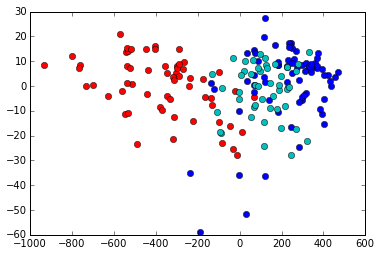

In [63]:
pca = PCA(n_components=2)
wineRep = pca.fit_transform(wineX)
plot2d(wineRep[:,0],wineRep[:,1],wineY)

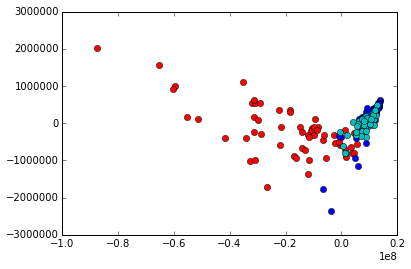

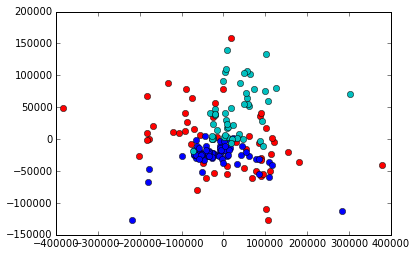

In [19]:
kpca = KernelPCA(n_components=4,kernel='poly')
wineRep = kpca.fit_transform(wineX)
winePlot(wineRep[:,0],wineRep[:,1],wineY)
winePlot(wineRep[:,2],wineRep[:,3],wineY)

In [31]:
import plotly.tools as tls
tls.set_credentials_file(username='babak', api_key='2ckqbl8or0')

In [54]:
import plotly.plotly as py
import plotly.graph_objs as go
def plot3Dsimple(x1,x2,x3,y):
    trace1 = go.Scatter3d(
        x=x1[y==0],
        y=x2[y==0],
        z=x3[y==0],
        mode='markers',
        marker=dict(
            size=2,
            color='rgb(228,26,28)',          
            symbol='circle',
            opacity=1
        )
    )


    trace2 = go.Scatter3d(
        x=x1[y==1],
        y=x2[y==1],
        z=x3[y==1],
        mode='markers',
        marker=dict(
            color='rgb(55,126,184)',
            size=2,
            symbol='circle',
            opacity=1
        )
    )

    trace3 = go.Scatter3d(
        x=x1[y==2],
        y=x2[y==2],
        z=x3[y==2],
        mode='markers',
        marker=dict(
            color='rgb(77,175,74)',
            size=2,
            symbol='circle',
            opacity=1
        )
    )


    data = [trace1, trace2,trace3]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='simple-3d-scatter')

In [59]:

wineRepKPCA = kpca.fit_transform(wineX)

x1 = wineRepKPCA[:,0]
x2 = wineRepKPCA[:,1]
x3 = wineRepKPCA[:,2]
y = wineY

plot3Dsimple(x1,x2,x3,y)

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~babak/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


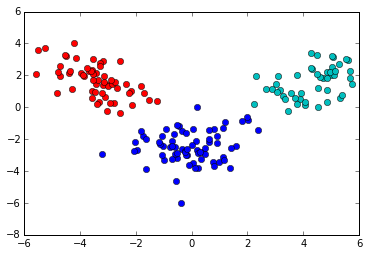

In [64]:
from sklearn.lda import LDA
clf = LDA()
clf.fit(wineX, wineY)
newRepLDA = clf.transform(wineX)
plot2d(newRepLDA[:,0],newRepLDA[:,1],wineY)

In [69]:
def LDA10FoldRepresentation(X,y):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        print '---------------------------------------', i
        yTest = y[test_index]
        yTrain = y[train_index]
        clf = LDA()
        clf.fit(X[train_index], yTrain)
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])
        
        print 'train'
        plot2d(newRepTrain[:,0],newRepTrain[:,1],yTrain)
        print 'test'
        plot2d(newRepTest[:,0],newRepTest[:,1],yTest)
        i += 1
def KPCA10FoldRepresentation(X,y):
    acc = []
    kf = KFold(X.shape[0],n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        yTest = y[test_index]
        yTrain = y[train_index]
        clf = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
        clf.fit(X[train_index])
        newRepTrain = clf.transform(X[train_index])
        newRepTest = clf.transform(X[test_index])
        
        print 'train'
        plot2d(newRepTrain[:,0],newRepTrain[:,1],yTrain)
        print 'test'
        plot2d(newRepTest[:,0],newRepTest[:,1],yTest)
        
        i += 1

--------------------------------------- 0
train


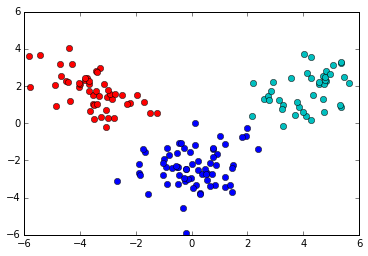

test


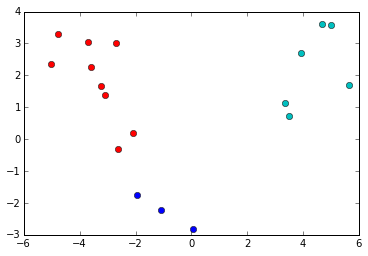

--------------------------------------- 1
train


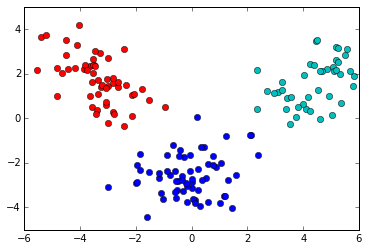

test


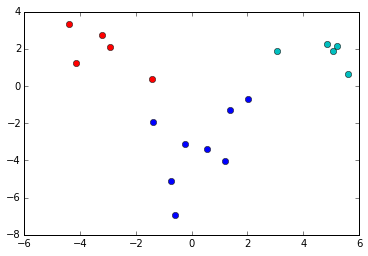

--------------------------------------- 2
train


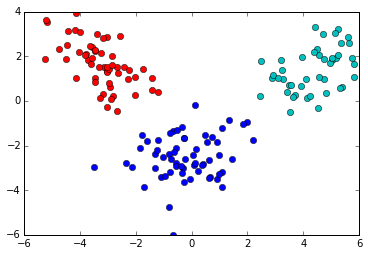

test


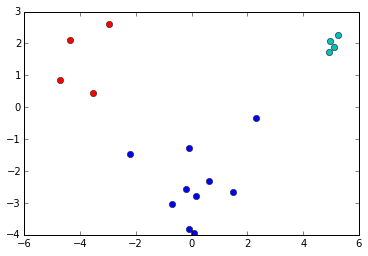

--------------------------------------- 3
train


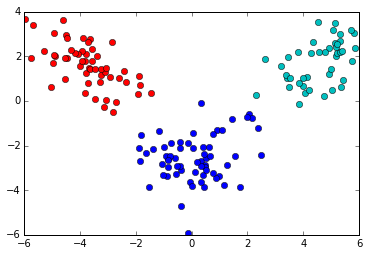

test


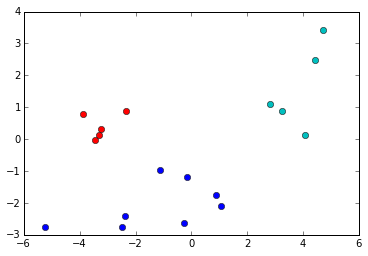

--------------------------------------- 4
train


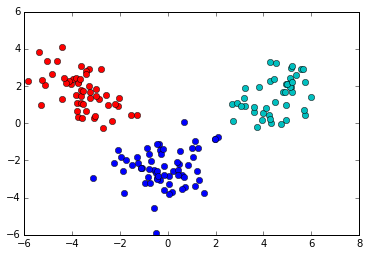

test


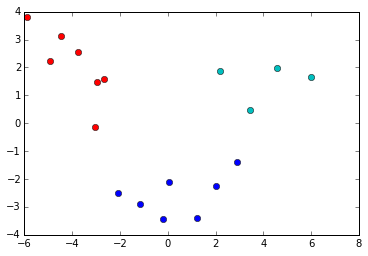

--------------------------------------- 5
train


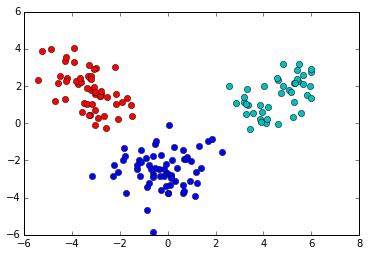

test


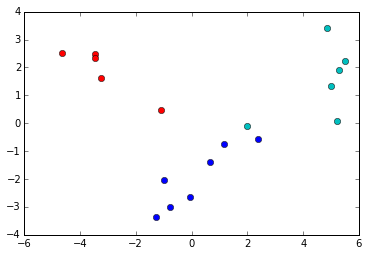

--------------------------------------- 6
train


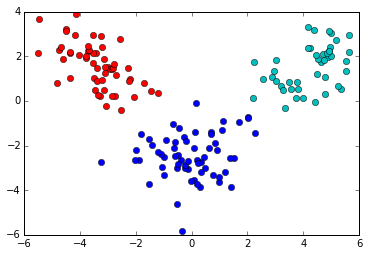

test


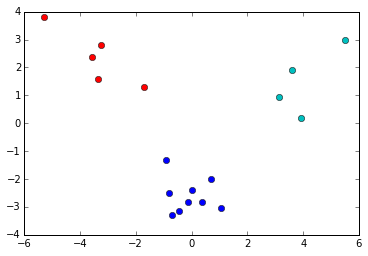

--------------------------------------- 7
train


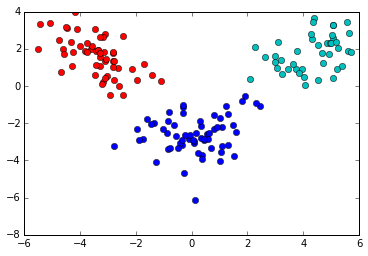

test


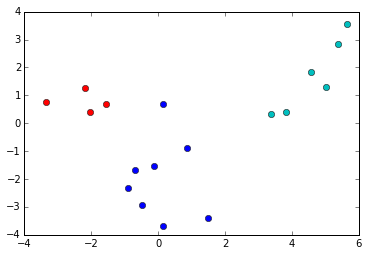

--------------------------------------- 8
train


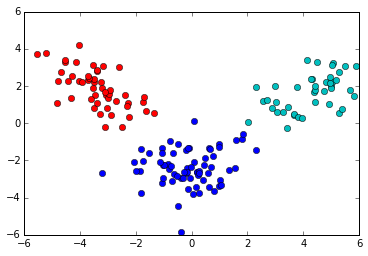

test


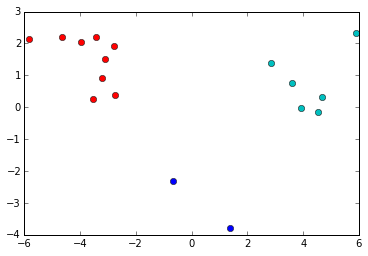

--------------------------------------- 9
train


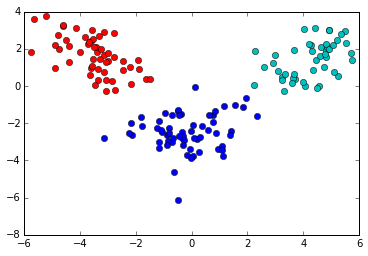

test


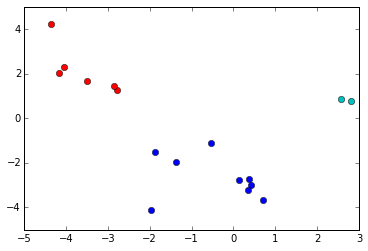

nan

In [68]:
LDA10FoldRepresentation(wineX,wineY)

train


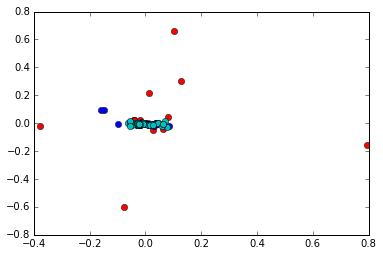

test


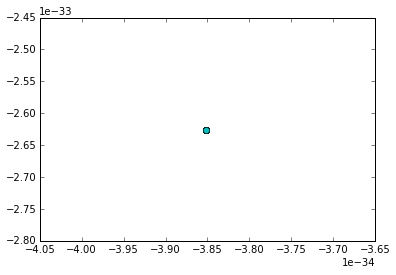

train


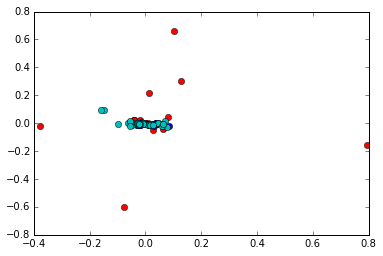

test


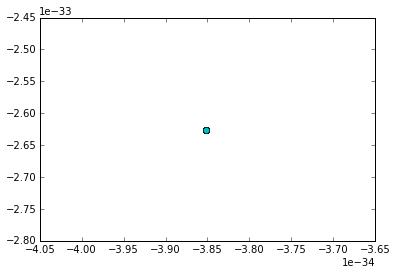

train


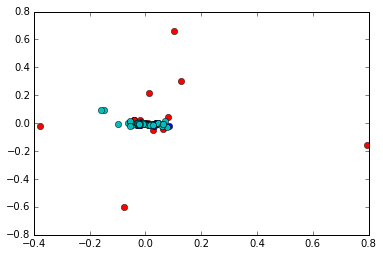

test


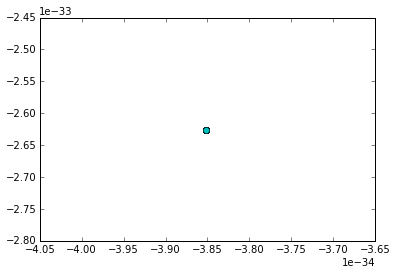

train


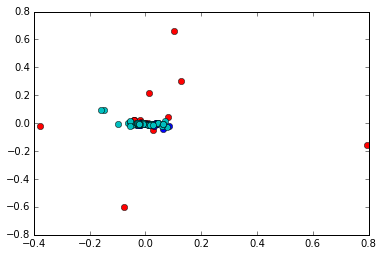

test


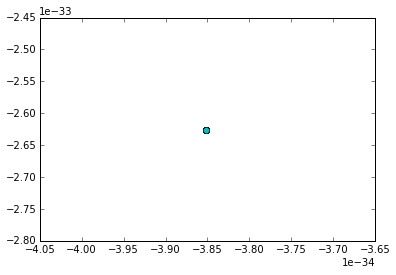

train


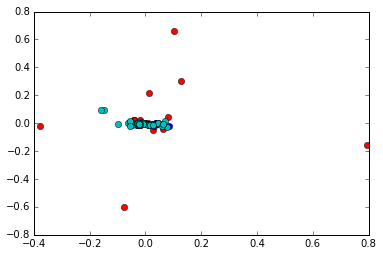

test


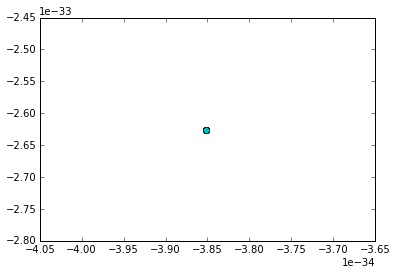

train


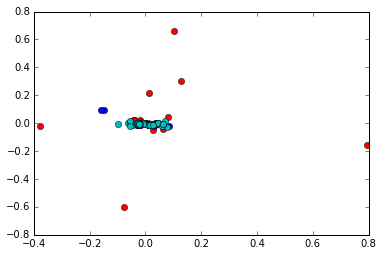

test


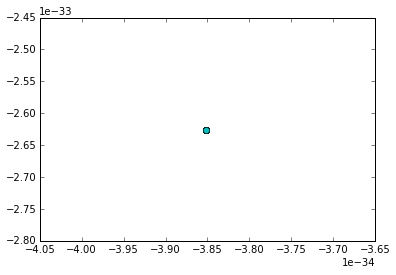

train


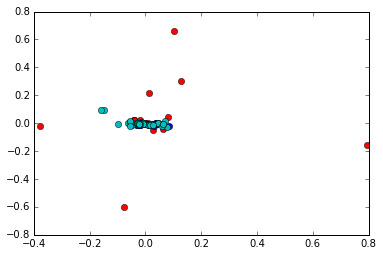

test


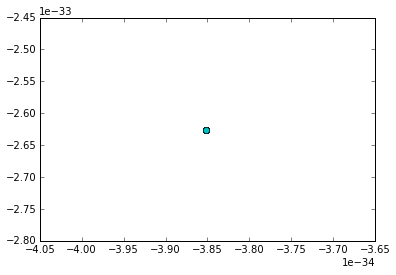

train


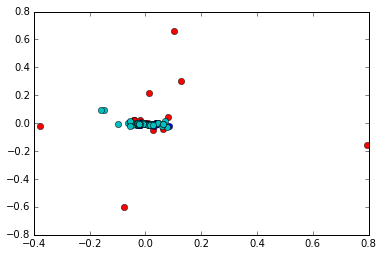

test


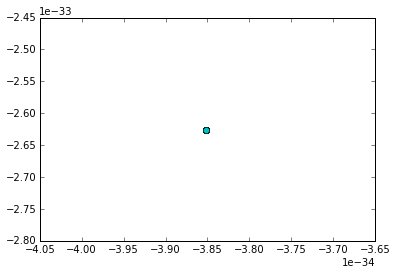

train


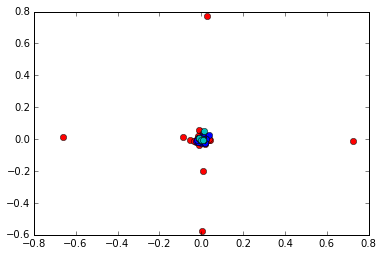

test


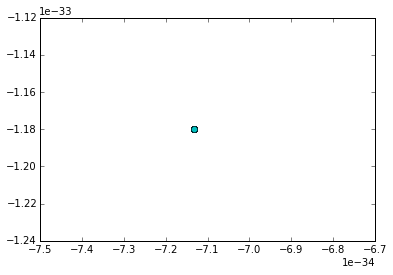

train


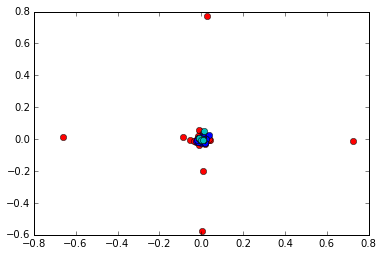

test


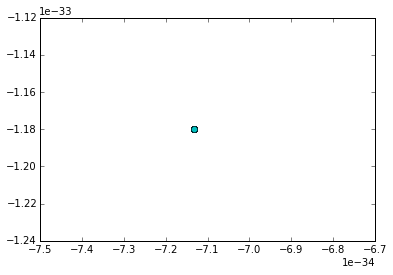

In [70]:
KPCA10FoldRepresentation(wineX,wineY)

In [85]:
glassX.shape

(214L, 9L)

array([ 13.00061798,   2.33634831])

In [86]:
tmp = [0.68006535947712421,
 0.70816993464052291,
 0.68071895424836604,
 0.684640522875817,
 0.70326797385620909,
 0.70228758169934635,
 0.70686274509803915,
 0.69738562091503264,
 0.67483660130718959,
 0.68529411764705883,
 0.6892156862745098,
 0.70228758169934635,
 0.69477124183006533,
 0.68594771241830066,
 0.67352941176470593,
 0.68529411764705883,
 0.68627450980392157,
 0.69052287581699345,
 0.68594771241830066,
 0.69183006535947711]

In [87]:
np.mean(tmp),np.std(tmp)

(0.69045751633986918, 0.0099389395583112747)

In [1]:
from sklearn.datasets import load_digits
dataset = load_digits()

In [4]:
dataset.data.shape

(1797L, 64L)

In [6]:
dataset.target

array([0, 1, 2, ..., 8, 9, 8])